In [1]:
import logging
logging.disable(logging.INFO)

In [2]:
# We download an extract of Kuzak Dempsy's dataset that also can be found here:
# https://raw.githubusercontent.com/vserret/datasets/main/heart_data.csv
!wget https://raw.githubusercontent.com/vserret/datasets/main/heart_data.csv

--2023-08-03 17:46:00--  https://raw.githubusercontent.com/vserret/datasets/main/heart_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2941524 (2,8M) [text/plain]
Saving to: ‘heart_data.csv’

heart_data.csv      100%[===================>]   2,80M  --.-KB/s    in 0,1s    

2023-08-03 17:46:01 (20,6 MB/s) - ‘heart_data.csv’ saved [2941524/2941524]



In [3]:
from pyqrlew.io.sqlite import SQLite
table_name = "heart_data"
csv_file = "heart_data.csv"
db = SQLite(table_name, csv_file)

In [4]:
import pandas as pd
pd.DataFrame(db.execute("SELECT * FROM heart_data")).head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
ds = db.dataset()
ds.relations()

[(['heart_data'], <Relation at 0x10f81bf30>)]

In [6]:
import graphviz

def display_dot(dot_graph): 
    display(graphviz.Source(dot_graph))

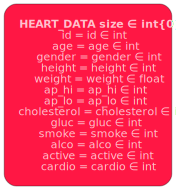

In [7]:
display_dot(ds.relations()[0][1].dot())

In [8]:
pd.DataFrame(db.execute('SELECT * FROM heart_data')).head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


The min and max values for bmi: [15.359168241965973, 38.19297095019482]
The propagated datatype is: {bmi: float[13.149243918474689 39.06249999999999]}


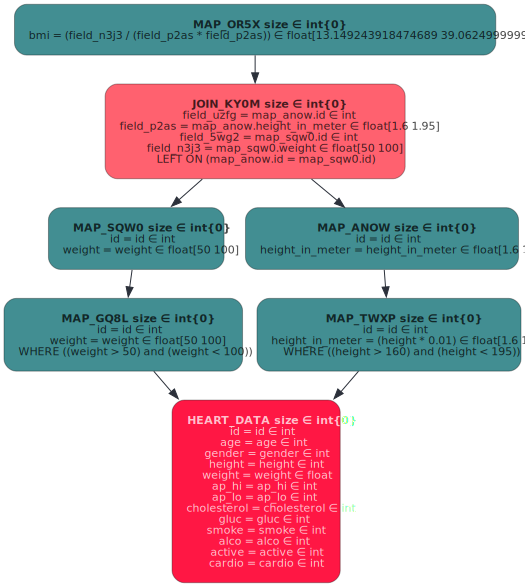

In [41]:
# BMI = weight(kg) / height_m ** 2
query = """
WITH 
    height_table AS (SELECT id, height_in_meter AS height_in_meter FROM (SELECT id, height * 0.01 AS height_in_meter FROM heart_data WHERE height > 160 AND height < 195) AS subq),
    weight_table AS (SELECT id, weight AS weight FROM (SELECT id, weight FROM heart_data WHERE weight > 50 AND weight < 100) AS subq)
SELECT weight / (height_in_meter * height_in_meter) AS bmi FROM height_table LEFT JOIN weight_table ON height_table.id = weight_table.id
"""
relation = ds.sql(query)

df0 = pd.DataFrame(db.eval(relation))
print(f"The min and max values for bmi: [{df0['bmi'].min()}, {df0['bmi'].max()}]")
print(f"The propagated datatype is: {relation.schema()}")    

display_dot(relation.dot())

In [43]:
df = pd.read_csv('./heart_data.csv')
df['height'].unique()

array([168, 156, 165, 169, 151, 157, 178, 158, 164, 173, 181, 172, 170,
       154, 162, 163, 153, 159, 166, 155, 160, 175, 171, 152, 187, 148,
       179, 180, 188, 185, 167, 183, 174, 176, 161, 184, 177, 182,  76,
       149, 142, 150, 144, 147, 186, 146, 141, 195, 140, 198, 145, 143,
       196, 138, 194, 190, 134, 136, 100, 120, 189, 137, 192, 122, 250,
       191, 117,  70,  97, 119, 130, 110, 193,  75, 132,  71, 135,  67,
       125, 139, 133,  74,  98, 112, 207,  68,  55,  81,  80,  64,  91,
        60, 109,  72, 197,  65, 128, 105, 108, 200, 104, 111, 113,  96,
       131,  59,  66,  99,  57])

The min and max values for bmi: [18.069727891156464, 41.05029585798817]
The propagated datatype is: {bmi: float[17.71541950113379 41.0913872452334]}


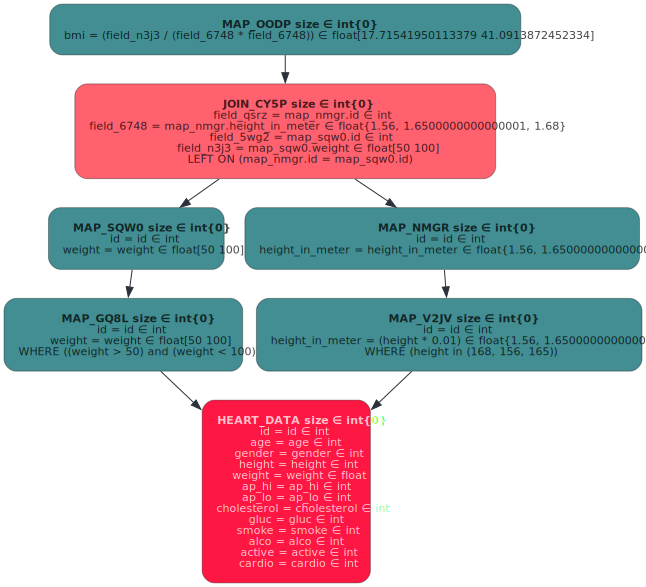

In [44]:
# BMI = weight(kg) / height_m ** 2
query = """
WITH 
    height_table AS (SELECT id, height_in_meter AS height_in_meter FROM (SELECT id, height * 0.01 AS height_in_meter FROM heart_data WHERE height in (168, 156, 165)) AS subq),
    weight_table AS (SELECT id, weight AS weight FROM (SELECT id, weight FROM heart_data WHERE weight > 50 AND weight < 100) AS subq)
SELECT weight / (height_in_meter * height_in_meter) AS bmi FROM height_table LEFT JOIN weight_table ON height_table.id = weight_table.id
"""
relation = ds.sql(query)

df0 = pd.DataFrame(db.eval(relation))
print(f"The min and max values for bmi: [{df0['bmi'].min()}, {df0['bmi'].max()}]")
print(f"The propagated datatype is: {relation.schema()}")    

display_dot(relation.dot())

The min and max values for lorentz: [56.6, 76.4]
The propagated datatype is: {lorentz: float[42 92.5]}


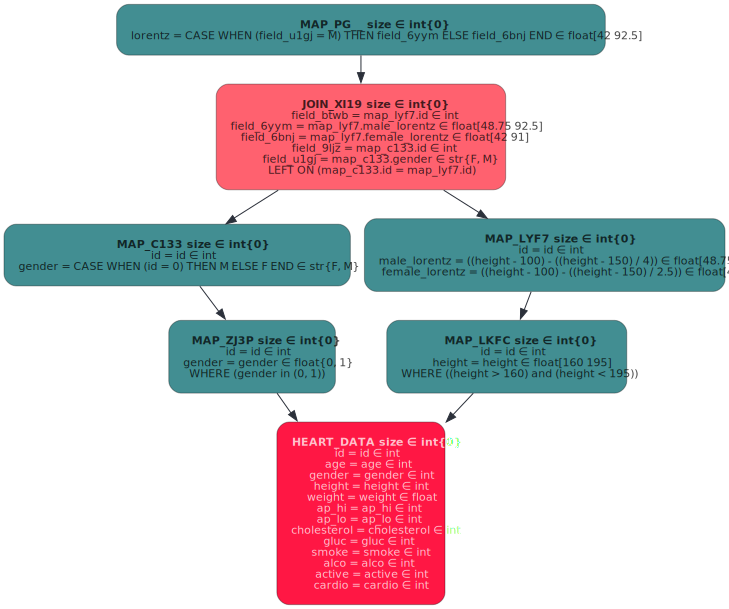

In [40]:
#Lorentz formula
#if gender='M', height(cm) - 100 - ((height(cm) - 150) / 4)
#if gender='F', height(cm) - 100 - ((height(cm) - 150) / 2,5).

query = """
WITH 
    height_table AS (SELECT id, height FROM heart_data WHERE height > 160 AND height < 195),
    lorentz_table AS (SELECT id, (height - 100 - (height - 150)/4) AS male_lorentz, (height - 100 - (height - 150)/2.5) AS female_lorentz FROM height_table),
    gender_table AS (SELECT id, CASE WHEN id = 0 THEN 'M' ELSE 'F' END AS gender FROM (SELECT id, gender AS gender FROM heart_data WHERE gender in (0, 1)) AS subq)
SELECT CASE WHEN gender = 'M' THEN male_lorentz ELSE female_lorentz END AS lorentz FROM lorentz_table LEFT JOIN gender_table ON gender_table.id = lorentz_table.id
"""
relation = ds.sql(query)

df0 = pd.DataFrame(db.eval(relation))
print(f"The min and max values for lorentz: [{df0['lorentz'].min()}, {df0['lorentz'].max()}]")
print(f"The propagated datatype is: {relation.schema()}")  

display_dot(relation.dot())

The min and max values for creff: [57.6, 88.2]
The propagated datatype is: {creff: float[56.7 90]}


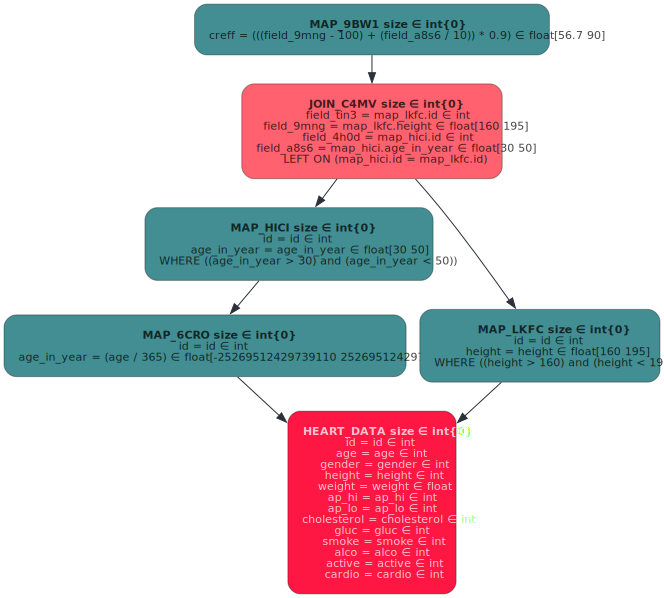

In [39]:
# creff [height(cm) - 100 + age(year) / 10] * 0,9

query = """
WITH 
    height_table AS (SELECT id, height FROM heart_data WHERE height > 160 AND height < 195),
    age_table AS (SELECT id, age_in_year FROM (SELECT id, (age / 365) AS age_in_year FROM heart_data) AS subq WHERE age_in_year > 30 AND age_in_year < 50)
SELECT (height - 100 + age_in_year / 10) * 0.9 AS creff FROM height_table LEFT JOIN age_table ON age_table.id = height_table.id
"""
relation = ds.sql(query)

df0 = pd.DataFrame(db.eval(relation))
print(f"The min and max values for creff: [{df0['creff'].min()}, {df0['creff'].max()}]")
print(f"The propagated datatype is: {relation.schema()}")

display_dot(relation.dot())